# The TF-IDF Baseline model

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

In [4]:
df = pd.read_csv("merged_dataset.csv")  # Change this to your actual file name

In [8]:
# 1. Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['content'])
y = df['label']

# 2. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 3. Train a classifier
model = LogisticRegression()
model.fit(X_train, y_train)

# 4. Predict and evaluate
preds = model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, preds) * 100,3),"%")


Accuracy: 85.233 %


# The fine-tuned BERT model

In [9]:
! pip install transformers datasets scikit-learn torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler

In [13]:
# Load your dataset
df = pd.read_csv("merged_dataset.csv")

label_map = {
    'Reliable': 0,
    'Misinformation': 1
}

df['label'] = df['label'].map(label_map)

df['label'] = df['label'].astype(int)

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['content'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
# Dataset class
class PostDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            **{key: torch.tensor(val[idx]) for key, val in self.encodings.items()},
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = PostDataset(train_encodings, train_labels)
val_dataset = PostDataset(val_encodings, val_labels)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [15]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Training setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
# Training loop
model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch+1} complete")

Epoch 1 complete
Epoch 2 complete
Epoch 3 complete


In [17]:
# Evaluation
model.eval()
preds, true = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true.extend(batch['labels'].cpu().numpy())

print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1342
           1       0.91      0.85      0.88      1238

    accuracy                           0.89      2580
   macro avg       0.89      0.89      0.89      2580
weighted avg       0.89      0.89      0.89      2580



### save the model and tokenizer

In [18]:
# Save directory
save_directory = "./bert_misinformation_model"

# Save model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./bert_misinformation_model/tokenizer_config.json',
 './bert_misinformation_model/special_tokens_map.json',
 './bert_misinformation_model/vocab.txt',
 './bert_misinformation_model/added_tokens.json')

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

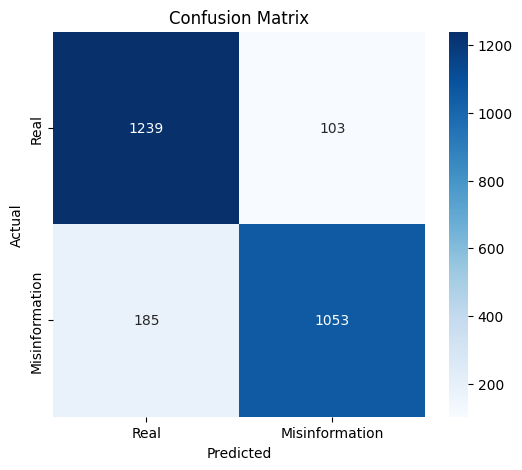

In [20]:
# Get the confusion matrix
cm = confusion_matrix(true, preds)

# Plot using seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Misinformation'], yticklabels=['Real', 'Misinformation'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
from sklearn.metrics import classification_report
import pandas as pd

# Create the report
report = classification_report(true, preds, target_names=["Real", "Misinformation"], output_dict=True)

# Convert to DataFrame for table view
report_df = pd.DataFrame(report).transpose()
display(report_df)

,precision,recall,f1-score,support
Real,0.870084,0.923249,0.895879,1342.000000
Misinformation,0.910900,0.850565,0.879699,1238.000000
accuracy,0.888372,0.888372,0.888372,0.888372
macro avg,0.890492,0.886907,0.887789,2580.000000
weighted avg,0.889669,0.888372,0.888115,2580.000000


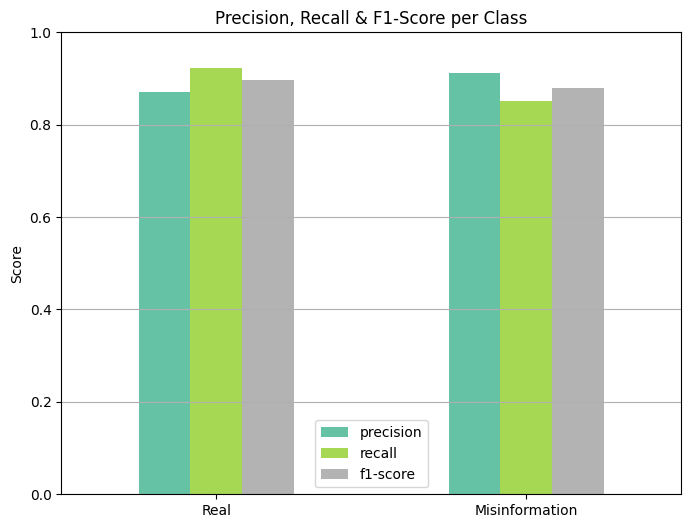

In [22]:
# Plot precision, recall, f1-score for each class
metrics = report_df.loc[["Real", "Misinformation"], ["precision", "recall", "f1-score"]]

metrics.plot(kind='bar', figsize=(8, 6), colormap="Set2")
plt.title("Precision, Recall & F1-Score per Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

### To reload the model for later usage

In [ ]:
# from transformers import BertTokenizer, BertForSequenceClassification

# # Load model and tokenizer from saved directory
# model = BertForSequenceClassification.from_pretrained("./bert_misinformation_model")
# tokenizer = BertTokenizer.from_pretrained("./bert_misinformation_model")